# Covid-19 Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [2]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 26/May/2020 08:06

# Covid-19 model dynamics on SD

On this notebook, we'll explore and visualize multiple models of covid-19 behavior in a dynamic system approach. The models were written on cadCAD - a library for Complex Adaptive Dynamics simulations which allows you to mix and prototype 
different modelling paradigms in a reproducible and consistent manner.

In [1]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [2]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x00000193CC8195C8>, <cadCAD.configuration.Configuration object at 0x00000193CC81DF48>, <cadCAD.configuration.Configuration object at 0x00000193CC82B448>]
Configurations: [<cadCAD.configuration.Configuration object at 0x00000193CC8195C8>, <cadCAD.configuration.Configuration object at 0x00000193CC81DF48>, <cadCAD.configuration.Configuration object at 0x00000193CC82B448>]
Execution in 1.8s


### Covid-19 SIR model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac{d}{dt}Infected}&=\beta * Infected * \frac {Susceptible}{Total Population} -\gamma * Infected
\\{\frac {d}{dt}Recovered}&=\gamma *Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1/D)



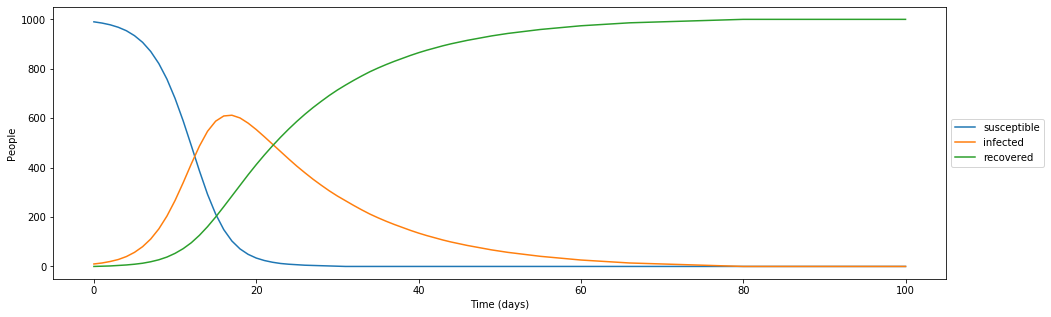

In [4]:
df = experiments.dataset[0] 
plt.rcParams["figure.figsize"]=20,5
fig, ax = plt.subplots()
ax.plot(df['timestep'], df['susceptible'], label='susceptible'  )
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

### Covid-19 SEIR model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - (1 - \alpha) * \gamma * Infected - \alpha* \rho* Infected
\\{\frac {d}{dt}Recovered}&=(1-\alpha)*\gamma*Infected
\\{\frac {d}{dt}Dead}&=\alpha*\rho*Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1/D)
- $\delta$ expected rate that exposed people turn into infected
- $\rho$ 



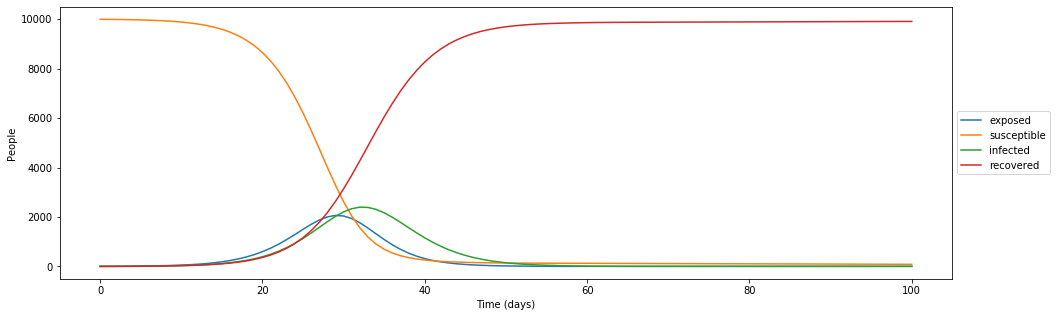

In [7]:
df = experiments.dataset[1] 
fig, ax = plt.subplots()
ax.plot(df['timestep'], df['exposed'], label='exposed')
ax.plot(df['timestep'], df['susceptible'], label='susceptible')
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

### Covid-19 SEIRD model

This is the standard introductory model for Covid-19 spread. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Susceptible}&= - \beta * Infected * {\frac {Susceptible}{Total Population}}
\\{\frac {d}{dt}Exposed}&=\beta * Infected * {\frac {Susceptible}{Total Population}} - \delta * Exposed 
\\{\frac{d}{dt}Infected}&=\delta * Exposed - (1 - \alpha) * \gamma * Infected - \alpha * \rho * Infected
\\{\frac {d}{dt}Recovered}&= (1 - \alpha) * \gamma *Infected
\\{\frac {d}{dt}Dead}&=\alpha * \rho * Infected\end{aligned}

Where the parameters are:
- $\beta$ expected amount of people an infected person infects per day
- $\gamma$ the proportion of infected recovering per day ($\gamma$ = 1 / D)
- $\delta$ expected rate that exposed people turn into infected
- $\rho$ rate at wich infected people die per day ($\rho$ = 1 / D)
- $\alpha$ death probability
- $R₀$: the total number of people an infected person infects (R₀ = β / γ)


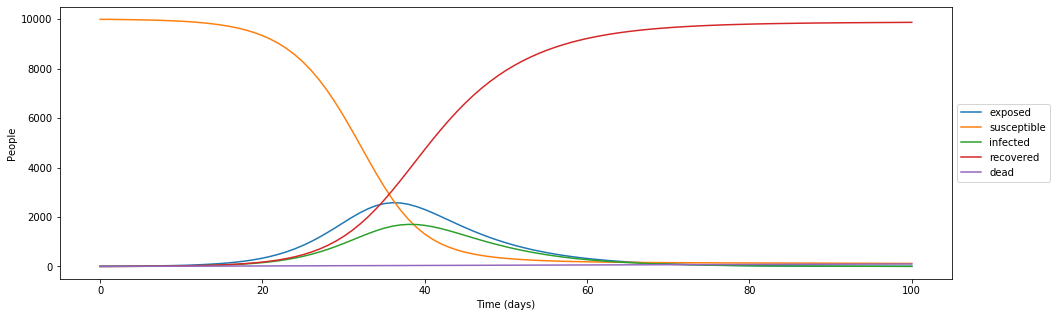

In [9]:
df = experiments.dataset[2] 
fig, ax = plt.subplots()
ax.plot(df['timestep'], df['exposed'], label='exposed')
ax.plot(df['timestep'], df['susceptible'], label='susceptible')
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
ax.plot(df['timestep'], df['dead'], label='dead')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

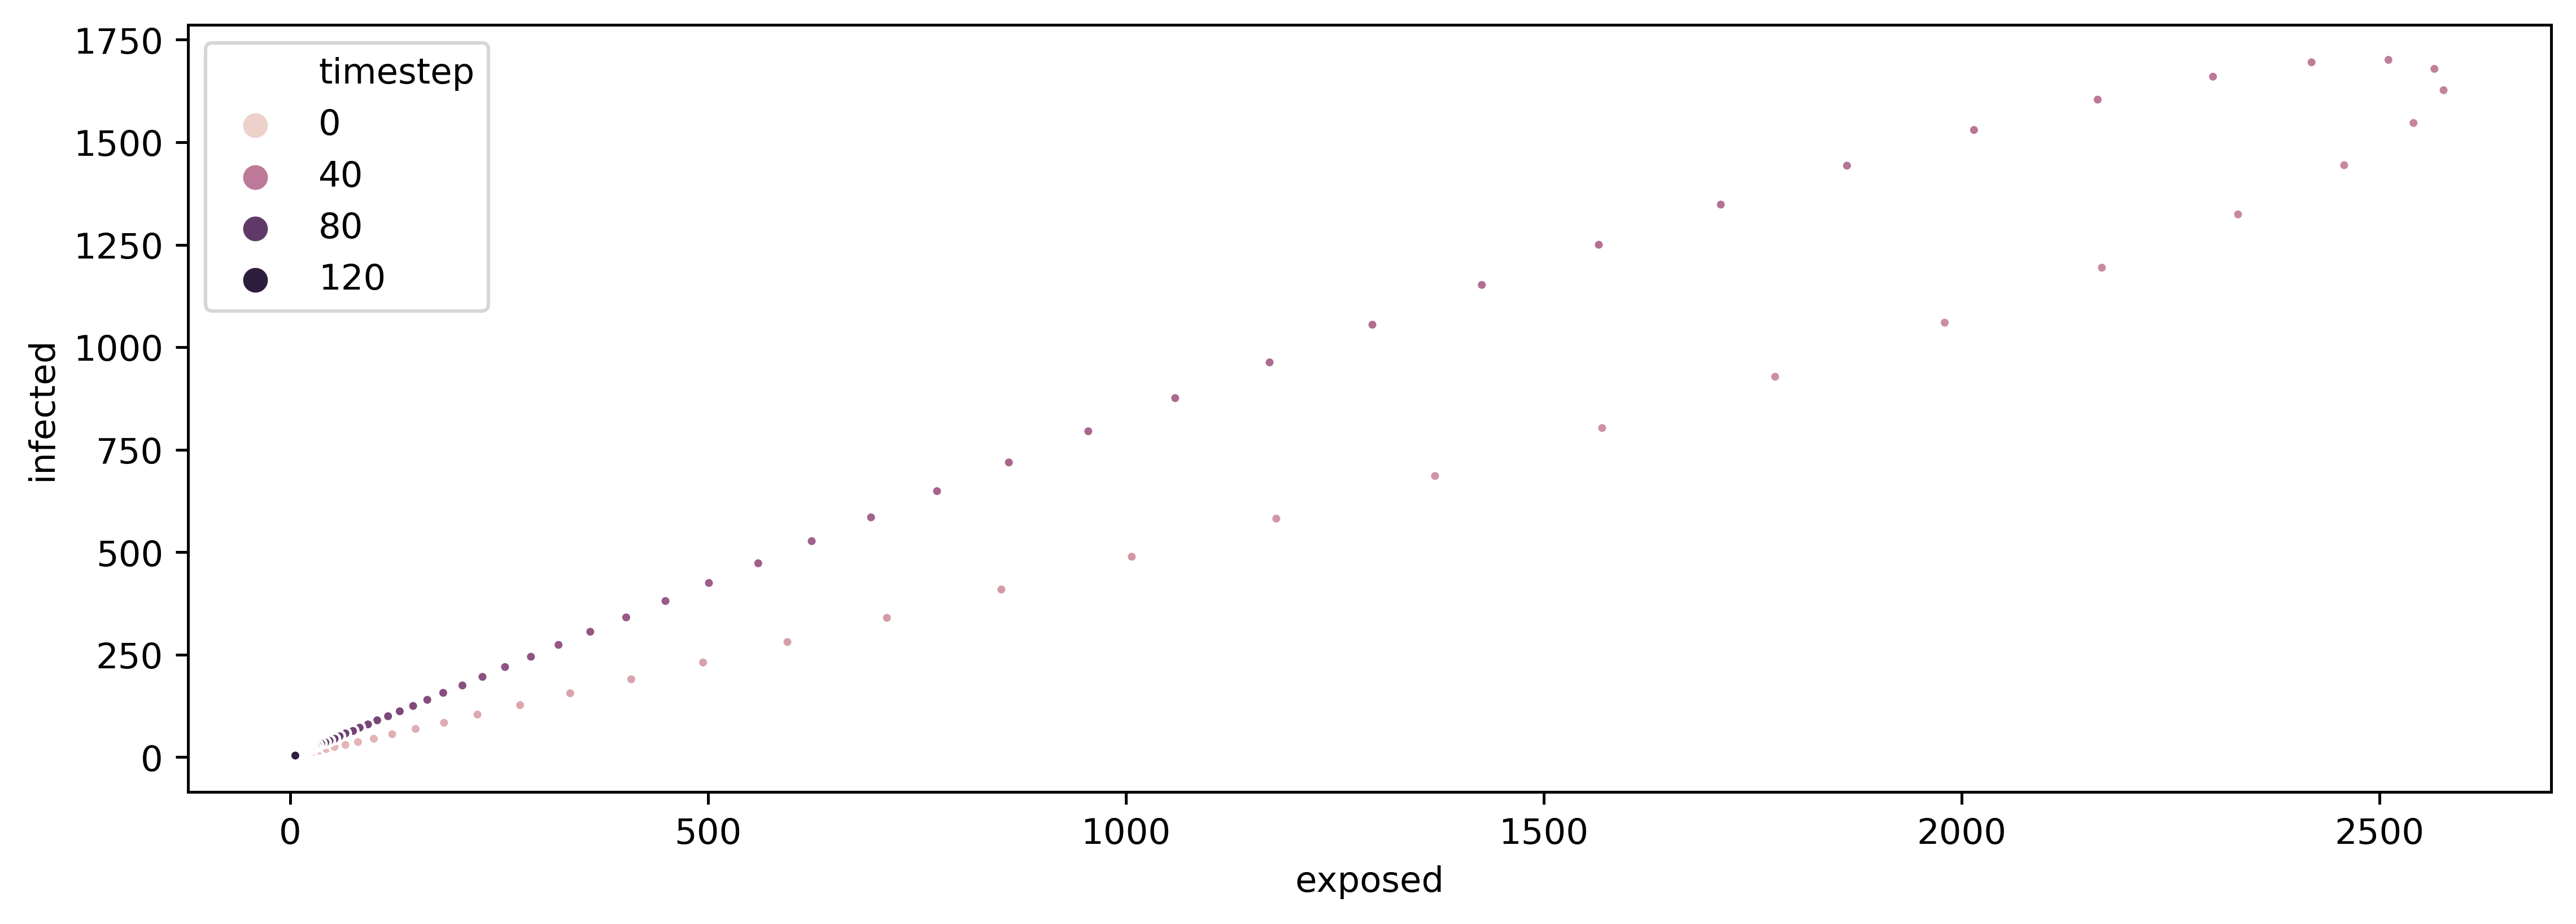

In [10]:
plt.figure(figsize=(12, 4), dpi=450)
sns.scatterplot(data=experiments.dataset[2],
                x='exposed',
                y='infected',
                hue='timestep',
                marker='.')
plt.show()

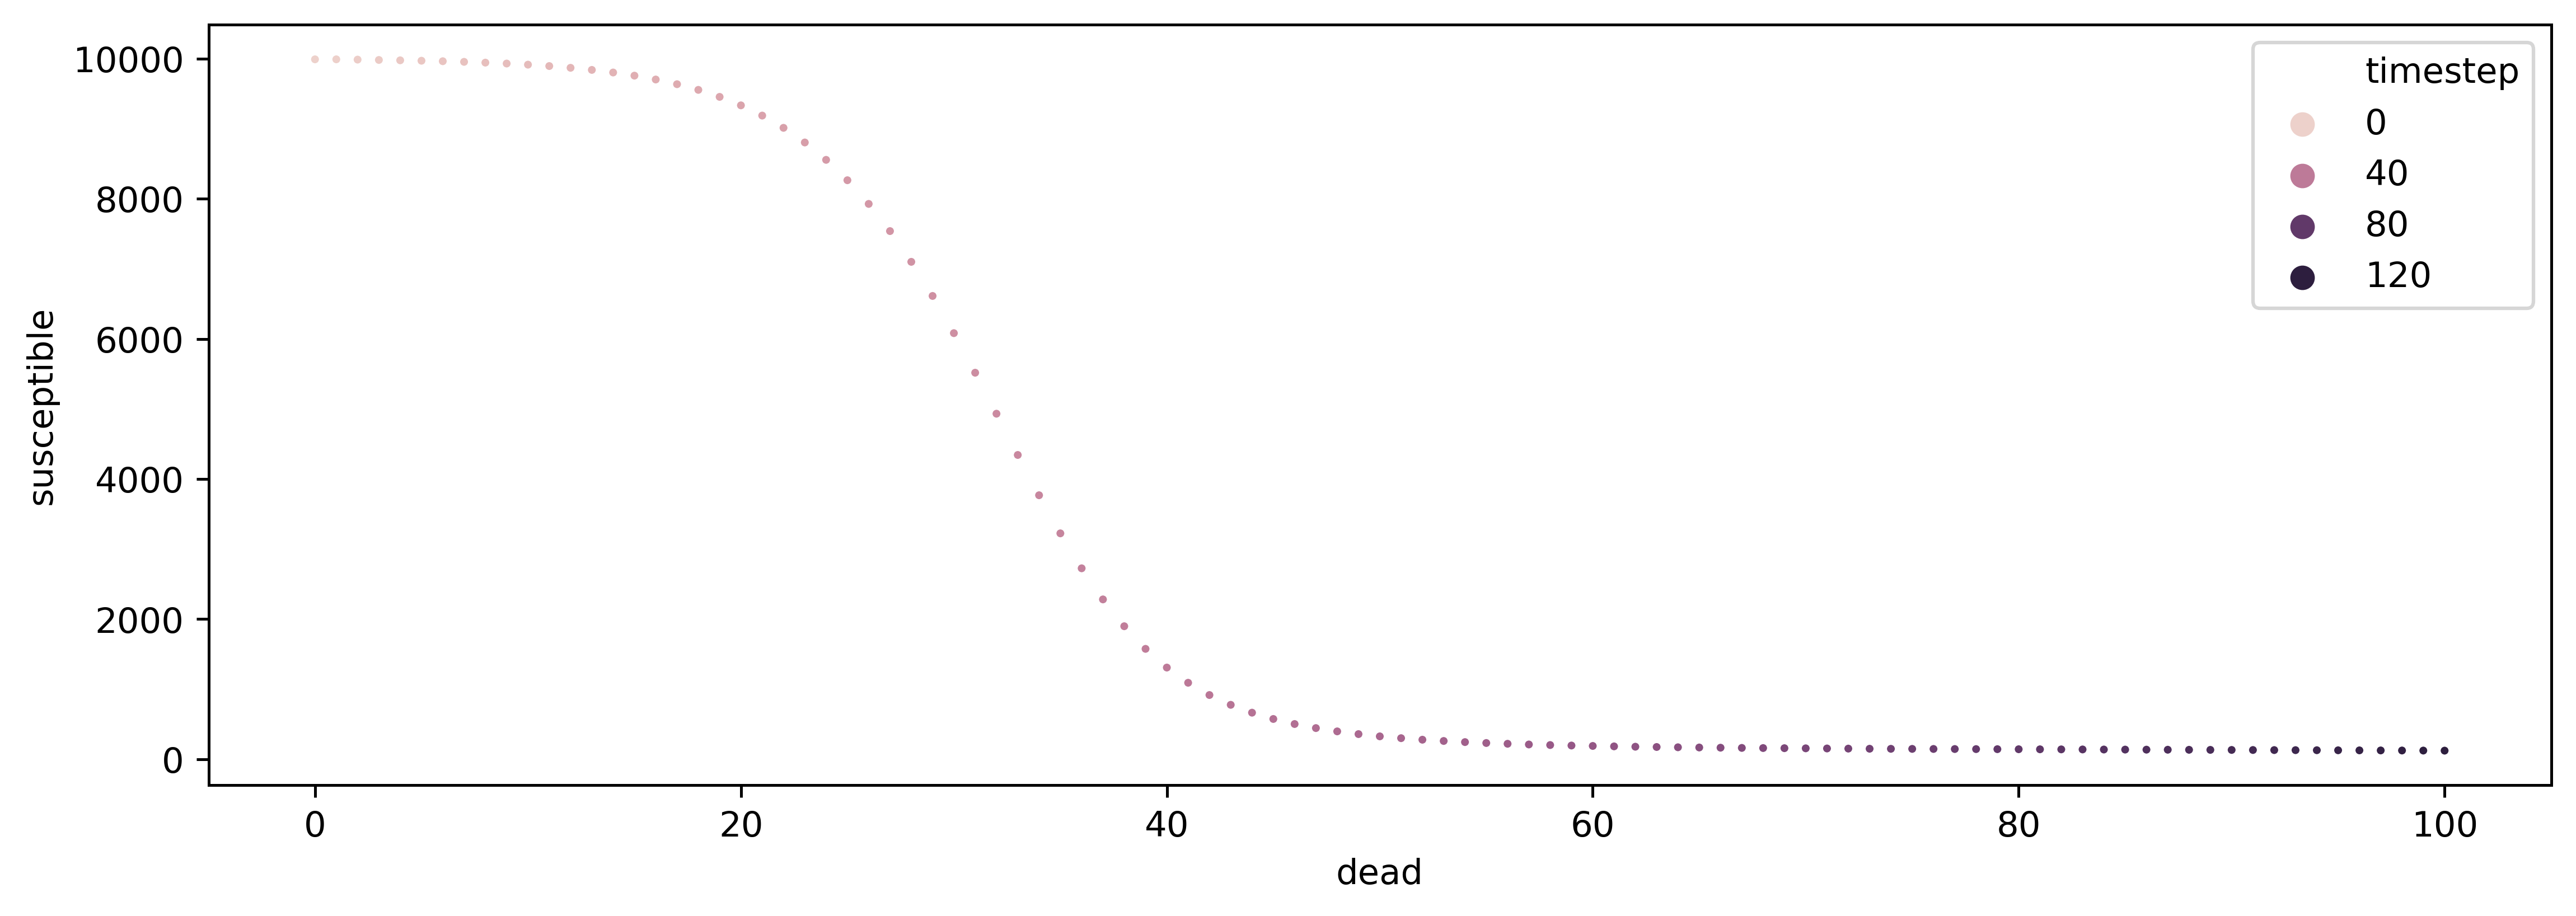

In [22]:
plt.figure(figsize=(12, 4), dpi=450)
sns.scatterplot(data=experiments.dataset[2],
                x='dead',
                y='susceptible',
                hue='timestep',
                marker='.')
plt.show()

### Conclusions and final words

### Proposed challenges

#### Make R₀ time dependent


#### Variable death rate



#### Stochasticity of the parameters



#### Add real data

